dfs = [contract, phone, internet]
dfs = [df.set_index('customerID') for df in dfs]
full_data = dfs[0].join(dfs[1:])
- хороший краткий способ объединять много таблиц

full_data['phone_services'].value_counts().plot(kind = 'bar', figsize = (15, 8), edgecolor = 'black')
plt.grid(zorder = 0)
plt.xlabel('использование телефонной связи', fontsize = 15)
plt.ylabel('количество клиентов', fontsize = 15)
plt.title('Доля пользователей телефонной связи', fontweight = 'bold', fontsize = 17)
plt.tick_params(axis='x', labelrotation = 0)


#Создам датасеты для построения диаграммы
df1=df.query('target==1')
phone1=phone.query('customerID in @df1.customerID')
internet1=internet.query('customerID in @df1.customerID')

# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<a id='shag_1'></a>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
from timeit import default_timer
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [2]:
path = 'C:/Users/GarySeldon/Downloads/final_provider/final_provider/'
contract = pd.read_csv(path+'contract.csv')
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
Clients = contract.loc[contract['EndDate']=='No','MonthlyCharges']
display(Clients.head())
NoClients = contract.loc[contract['EndDate']!='No','MonthlyCharges']
display(NoClients.head())

0    29.85
1    56.95
3    42.30
6    89.10
7    29.75
Name: MonthlyCharges, dtype: float64

2      53.85
4      70.70
5      99.65
8     104.80
13    103.70
Name: MonthlyCharges, dtype: float64

In [4]:
Clients.describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [5]:
NoClients.describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

Минимальные и максимальные значения групп равны, возможно связано с тарифами, но среднее значение и 25%, 75% заметно выше у тех, кто в дальнейшем отказался от услуг.

C:\Users\GarySeldon\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Распределение MonthlyCharges')

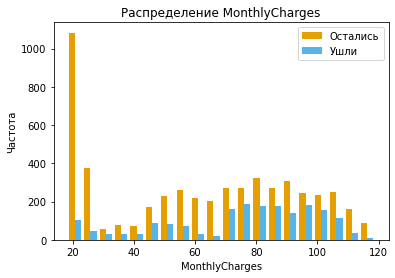

In [7]:
x1 = list(Clients)
x2 = list(NoClients)
colors = ['#E69F00', '#56B4E9']
names = ['Остались', 'Ушли']
         
plt.hist([x1, x2], bins = 20, color = colors, label=names)

plt.legend()
plt.xlabel('MonthlyCharges')
plt.ylabel('Частота')
plt.title('Распределение MonthlyCharges')

In [8]:
phone = pd.read_csv(path+'phone.csv')
display(phone.head())
internet = pd.read_csv(path+'internet.csv')
display(internet.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
df = pd.merge(contract, phone, how ='left', on ='customerID') 
df = pd.merge(df, internet, how ='left', on ='customerID') 
df = df[['EndDate','InternetService','MultipleLines']]
df = df.fillna('No')
display(df.head())

,EndDate,InternetService,MultipleLines
0,No,DSL,No
1,No,DSL,No
2,2019-12-01 00:00:00,DSL,No
3,No,DSL,No
4,2019-11-01 00:00:00,Fiber optic,No


In [17]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [19]:
Clients = df.loc[df['EndDate']=='No']
display(Clients.head())
NoClients = df.loc[df['EndDate']!='No']
display(NoClients.head())

,EndDate,InternetService,MultipleLines
0,No,DSL,No
1,No,DSL,No
3,No,DSL,No
6,No,Fiber optic,Yes
7,No,DSL,No


,EndDate,InternetService,MultipleLines
2,2019-12-01 00:00:00,DSL,No
4,2019-11-01 00:00:00,Fiber optic,No
5,2019-11-01 00:00:00,Fiber optic,Yes
8,2019-11-01 00:00:00,Fiber optic,Yes
13,2019-10-01 00:00:00,Fiber optic,Yes


InternetService : доля ушедших клиентов с признаком =  0.7269037495168148
InternetService : доля ушедших клиентов без признака =  0.27309625048318514


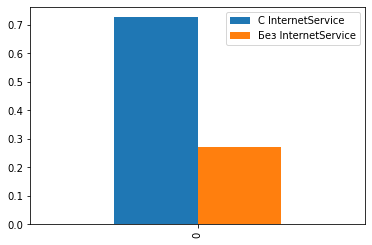

MultipleLines : доля ушедших клиентов с признаком =  0.4099342868187089
MultipleLines : доля ушедших клиентов без признака =  0.5900657131812911


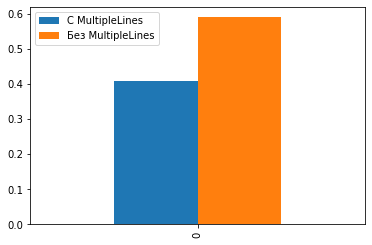

In [31]:
for priznak in ['InternetService','MultipleLines']:
    vsego = Clients[priznak].count()
    df_otn_s_uslugoy = Clients.loc[Clients[priznak]!='No']
    vsego_s_uslugoy = df_otn_s_uslugoy[priznak].count()

    df_otn_bez_uslugi = Clients.loc[Clients[priznak]=='No']
    vsego_bez_uslugi = df_otn_bez_uslugi[priznak].count()

    vs = df_otn_s_uslugoy['EndDate'].count()
    print(priznak,': доля ушедших клиентов с признаком = ', vs/vsego)
    vs2 = df_otn_bez_uslugi['EndDate'].count()
    print(priznak,': доля ушедших клиентов без признака = ', vs2/vsego)
    
    index = np.arange(2)
    data = {'С '+priznak: [vs/vsego],
            'Без '+priznak: [vs2/vsego]}
    df = pd.DataFrame(data)
    df.plot(kind='bar')
    plt.show()